# <span style="font-weight: bolder;">Spatial Clustering Demonstration of mouse visual cortex(Starmap)</span>
In this Tutorial, we demonstrate how to use 3d-OT to obtain the clustering results of mouse visual cortex

## <span style="font-weight: bolder;">Loading package </span>

In [1]:
from lib_3d_OT.utils import *
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from lib_3d_OT.single_modialty import *
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.3.2 
2: package ‘datasets’ was built under R version 4.3.2 
3: package ‘utils’ was built under R version 4.3.2 
4: package ‘grDevices’ was built under R version 4.3.2 
5: package ‘graphics’ was built under R version 4.3.2 
6: package ‘stats’ was built under R version 4.3.2 
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



In [2]:
import os
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## <span style="font-weight: bolder;">Loading and Pre-processing mouse visual cortex</span>
We use SCANPY package to select Top3000 HVGs and perform standard data processing,The standard processed expression matrix is `adata.X` is used as input

In [3]:
adata=sc.read_h5ad('/home/dbj/mouse/STARMAP/STARmap_20180505_BY3_1k.h5ad')
adata.obs['truth']=adata.obs['label']
adata.obs['day']=1
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
adata.obsm['feat']=adata.X

## <span style="font-weight: bolder;">The ground truth of mouse visual cortex</span>

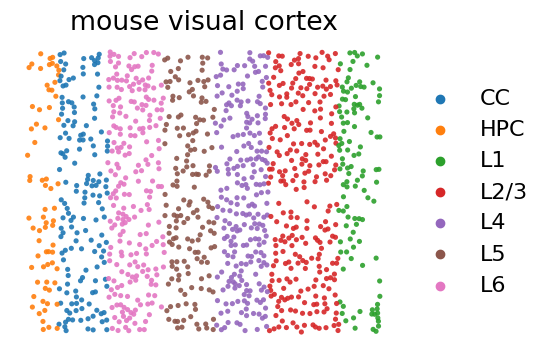

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['font.size'] = 16

# Create a figure and axis
fig, ax = plt.subplots()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_axis_off()
sc.pl.embedding(adata, color='truth', basis='spatial',title='mouse visual cortex',ax=ax, alpha=0.9, size=55)

## Constructing neighbor graph and training Pointnet++Encoder

In [5]:
set_seed(7)
graph = prepare_data(adata, location="spatial", nb_neighbors=10).to(device)
input_dim1 = graph.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model, min_loss = train_graph_extractor(graph, model, optimizer, device,epochs=1150)

Epoch 1150/1150, Loss: 0.637637, Min Loss: 0.637403

### Obtain the reconstruction matrix `decoded_features`

In [6]:
with torch.no_grad(): 
    model.eval()
    z= model.get_features(graph)
    decoded_features = model.decode(z)
    gene_expression_matrix = decoded_features.cpu().squeeze(0).detach().numpy()
adata.obsm['3d-OT']=gene_expression_matrix

## Clustering with mclust ,Clustering results can be found in `adata.obs['3d-OT']`

In [7]:
clustering(adata, n_clusters=7, radius=50, key='3d-OT', method='mclust', refinement=True,random=9,n_comp=20)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


## <span style="font-weight: bolder;">The clustering result of mouse visual cortex</span>

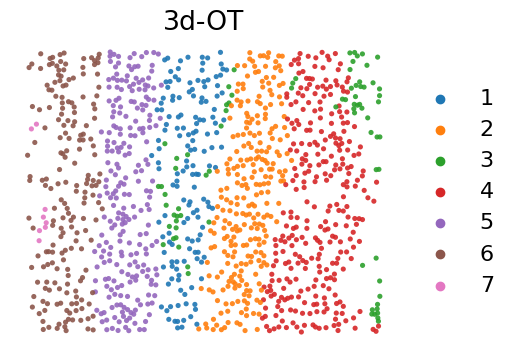

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['font.size'] = 16

# Create a figure and axis
fig, ax = plt.subplots()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_axis_off()
sc.pl.embedding(adata, color='3d-OT', basis='spatial',title='3d-OT',ax=ax, alpha=0.9, size=55)

## <span style="font-weight: bolder;">Quantitative evaluation of clustering performance</span>

In [9]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
ARI = adjusted_rand_score(adata.obs['truth'], adata.obs['3d-OT'])
NMI = normalized_mutual_info_score(adata.obs['truth'], adata.obs['3d-OT'])
ARI,NMI

(0.6218803843637293, 0.6925995174893972)